In [1]:
"""
Created on Fri Aug 30 12:34:38 2024

@author: Thierry ALLEM

" Recherche des meilleurs hyperparamètres pour application de l'algorithme XGBoost en modélisation segmentéE (par région)"
"""

'\nCreated on Fri Aug 30 12:34:38 2024\n\n@author: Thierry ALLEM\n\n" Recherche des meilleurs hyperparamètres pour application de l\'algorithme XGBoost en modélisation segmentéE (par région)"\n'

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
# Importation du fichier eco2mix_regional_def préparé, incluant les TCO, TCH, cmax_rte et les populations régionales
# Lecture du fichier CSV
df_blackout_ml = pd.read_csv('df_blackout_ML_pop.csv', sep=';',low_memory=False)
# Lecture du fichier CSV
df_blackout_ml.head()

,region,date_heure,annee,jour_numero,heure,jour_fractionnel,thermique,nucleaire,eolien,solaire,...,nucleaire_p_disp,eolien_p_disp,solaire_p_disp,cap_prod_max_hydraulique,ind_prod_hydraulique,hydraulique_p_disp,cap_prod_max_bioenergies,bioenergies_p_disp,region_p_max,population
0,CENTRE VAL DE LOIRE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,90.0,9085.0,508.0,0.0,...,11630.0,662.0,207.0,91.0,0.0,91.0,41.0,41.0,12788.0,2570548
1,PAYS DE LA LOIRE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,127.0,0.0,182.0,0.0,...,0.0,454.0,385.0,5.0,0.0,5.0,57.0,57.0,2738.0,3660852
2,GRAND EST,2013-01-01 00:30:00,2013,1,00:30:00,1.02,319.0,9137.0,1109.0,0.0,...,10820.0,1803.0,498.0,2280.0,0.0,2280.0,79.0,79.0,18878.0,5552388
3,ILE DE FRANCE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,685.0,0.0,16.0,0.0,...,0.0,37.0,108.0,19.0,0.0,19.0,262.0,262.0,2547.0,11959807
4,OCCITANIE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,78.0,2497.0,367.0,0.0,...,2620.0,861.0,1040.0,5368.0,0.0,5368.0,126.0,126.0,10260.0,5683878


In [4]:
# Filtrage des données pour les années 2013 à 2019
df_blackout_ml_13_19 = df_blackout_ml[(df_blackout_ml['annee'] >= 2013) & (df_blackout_ml['annee'] <= 2019)].copy()

In [5]:
# Encodages cycliques et autres transformations globales
df_blackout_ml_13_19['date_heure'] = pd.to_datetime(df_blackout_ml_13_19['date_heure'])
df_blackout_ml_13_19['heure_decimale'] = df_blackout_ml_13_19['date_heure'].dt.hour + df_blackout_ml_13_19['date_heure'].dt.minute / 60
df_blackout_ml_13_19['heure_decimale_sin'] = np.sin(2 * np.pi * df_blackout_ml_13_19['heure_decimale'] / 24)
df_blackout_ml_13_19['heure_decimale_cos'] = np.cos(2 * np.pi * df_blackout_ml_13_19['heure_decimale'] / 24)

In [6]:
def bissextile(annee):
    return annee % 4 == 0 and (annee % 100 != 0 or annee % 400 == 0)


In [7]:
df_blackout_ml_13_19['total_jours_annee'] = df_blackout_ml_13_19['annee'].apply(lambda annee: 366 if bissextile(annee) else 365)
df_blackout_ml_13_19['jour_fractionnel_sin'] = np.sin(2 * np.pi * df_blackout_ml_13_19['jour_fractionnel'] / df_blackout_ml_13_19['total_jours_annee'])
df_blackout_ml_13_19['jour_fractionnel_cos'] = np.cos(2 * np.pi * df_blackout_ml_13_19['jour_fractionnel'] / df_blackout_ml_13_19['total_jours_annee'])
df_blackout_ml_13_19 = df_blackout_ml_13_19.drop('total_jours_annee', axis=1)

In [8]:
# Préparation des données pour les années 2020 à 2023
df_blackout_ml_20_23_seg = df_blackout_ml[(df_blackout_ml['annee'] >= 2020) & (df_blackout_ml['annee'] <= 2023)].copy()
df_blackout_ml_20_23_seg['date_heure'] = pd.to_datetime(df_blackout_ml_20_23_seg['date_heure'])
df_blackout_ml_20_23_seg['heure_decimale'] = df_blackout_ml_20_23_seg['date_heure'].dt.hour + df_blackout_ml_20_23_seg['date_heure'].dt.minute / 60
df_blackout_ml_20_23_seg['heure_decimale_sin'] = np.sin(2 * np.pi * df_blackout_ml_20_23_seg['heure_decimale'] / 24)
df_blackout_ml_20_23_seg['heure_decimale_cos'] = np.cos(2 * np.pi * df_blackout_ml_20_23_seg['heure_decimale'] / 24)
df_blackout_ml_20_23_seg['total_jours_annee'] = df_blackout_ml_20_23_seg['annee'].apply(lambda annee: 366 if bissextile(annee) else 365)
df_blackout_ml_20_23_seg['jour_fractionnel_sin'] = np.sin(2 * np.pi * df_blackout_ml_20_23_seg['jour_fractionnel'] / df_blackout_ml_20_23_seg['total_jours_annee'])
df_blackout_ml_20_23_seg['jour_fractionnel_cos'] = np.cos(2 * np.pi * df_blackout_ml_20_23_seg['jour_fractionnel'] / df_blackout_ml_20_23_seg['total_jours_annee'])
df_blackout_ml_20_23_seg = df_blackout_ml_20_23_seg.drop('total_jours_annee', axis=1)

In [9]:
# Modélisation par segmentation
xgb_params = {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
metrics_results_seg = []
all_regions_df = []

In [10]:
# Fonction pour afficher l'importance des caractéristiques
def plot_feature_importance(model, features, region):
    importances = model.feature_importances_
    feature_names = features.columns
    
    # Création d'un DataFrame pour l'importance des caractéristiques
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Tri des caractéristiques par importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Création du graphique
    plt.figure(figsize=(12, 8))
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    
    # Ajout de labels et titre
    plt.xlabel('Importance')
    plt.ylabel('Caractéristiques')
    plt.title(f'Importance des variables explicatives pour {region}')
    
    # Affichage des valeurs sur les barres
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', 
                 va='center', ha='left', fontsize=10, color='black')
    
    # Enregistrement du graphique
    plt.tight_layout()
    plt.savefig(f'importance_features_XGB_{region}.png', dpi=300)
    plt.show()

Entraînement du modèle XGBoost pour la région CENTRE VAL DE LOIRE...


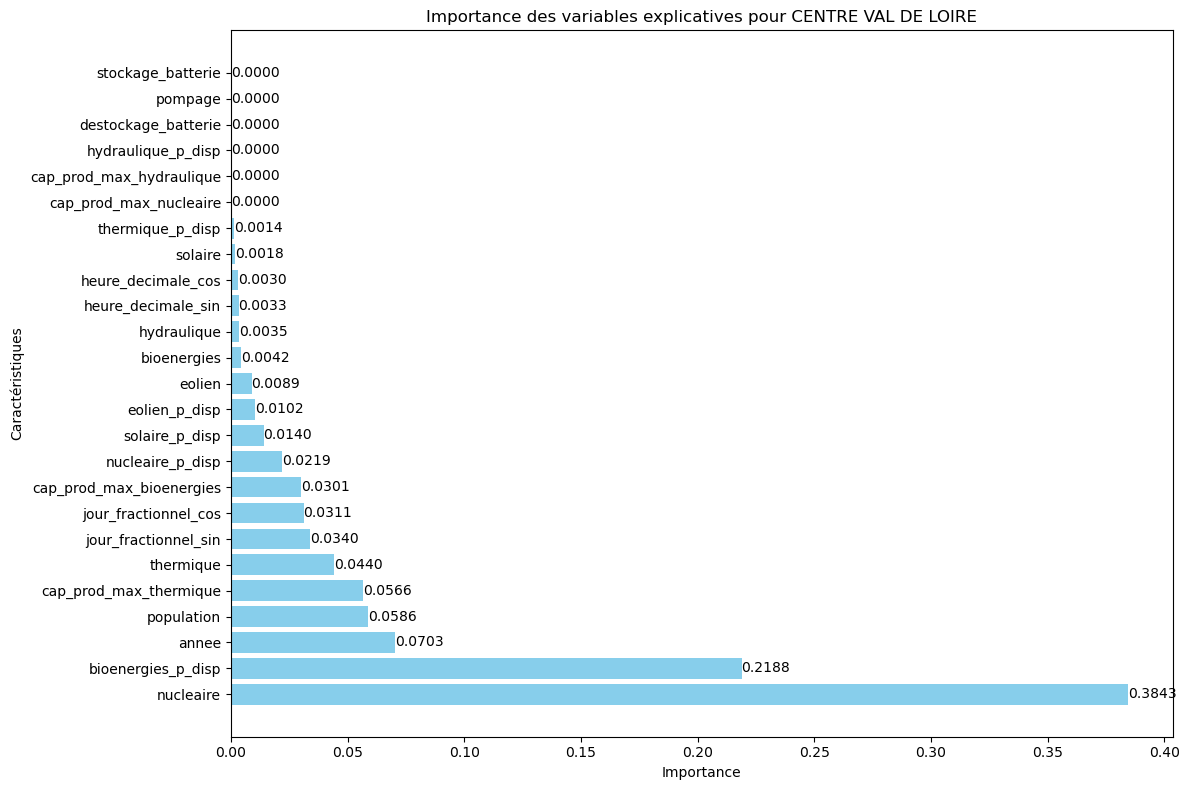

Entraînement du modèle XGBoost pour la région PAYS DE LA LOIRE...


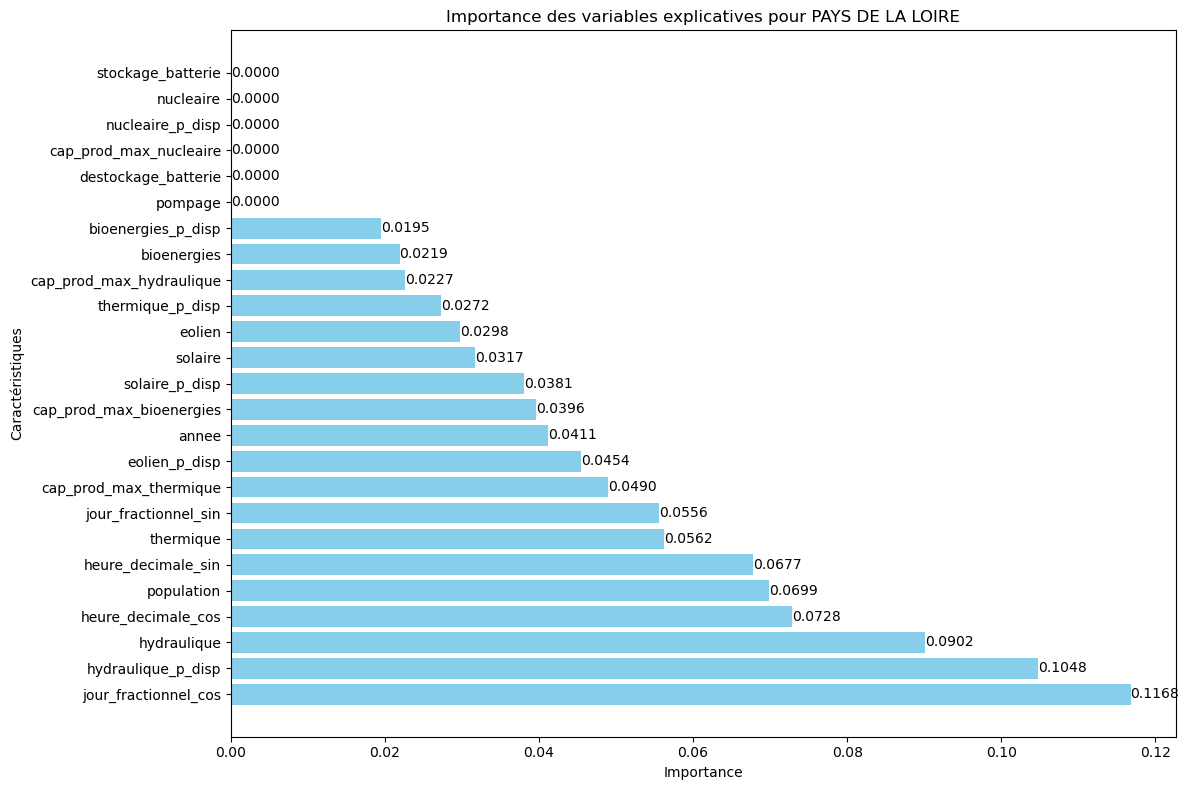

Entraînement du modèle XGBoost pour la région GRAND EST...


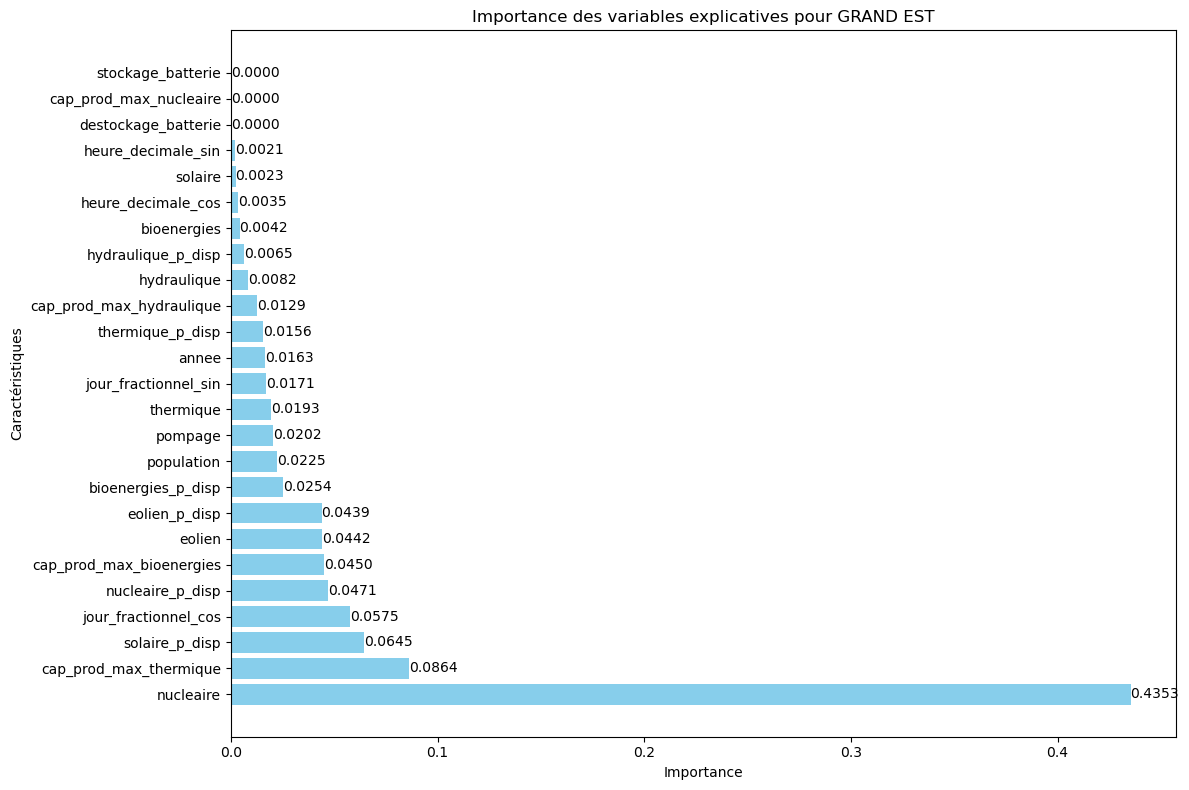

Entraînement du modèle XGBoost pour la région ILE DE FRANCE...


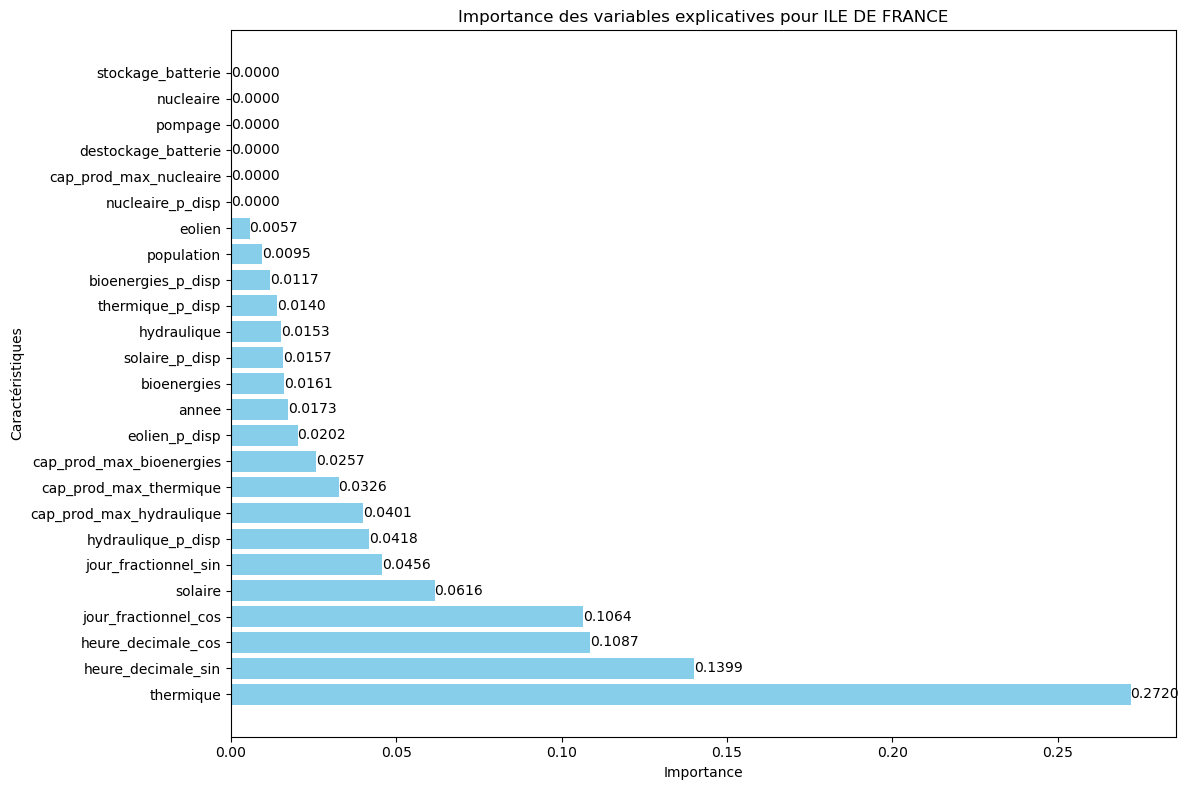

Entraînement du modèle XGBoost pour la région OCCITANIE...


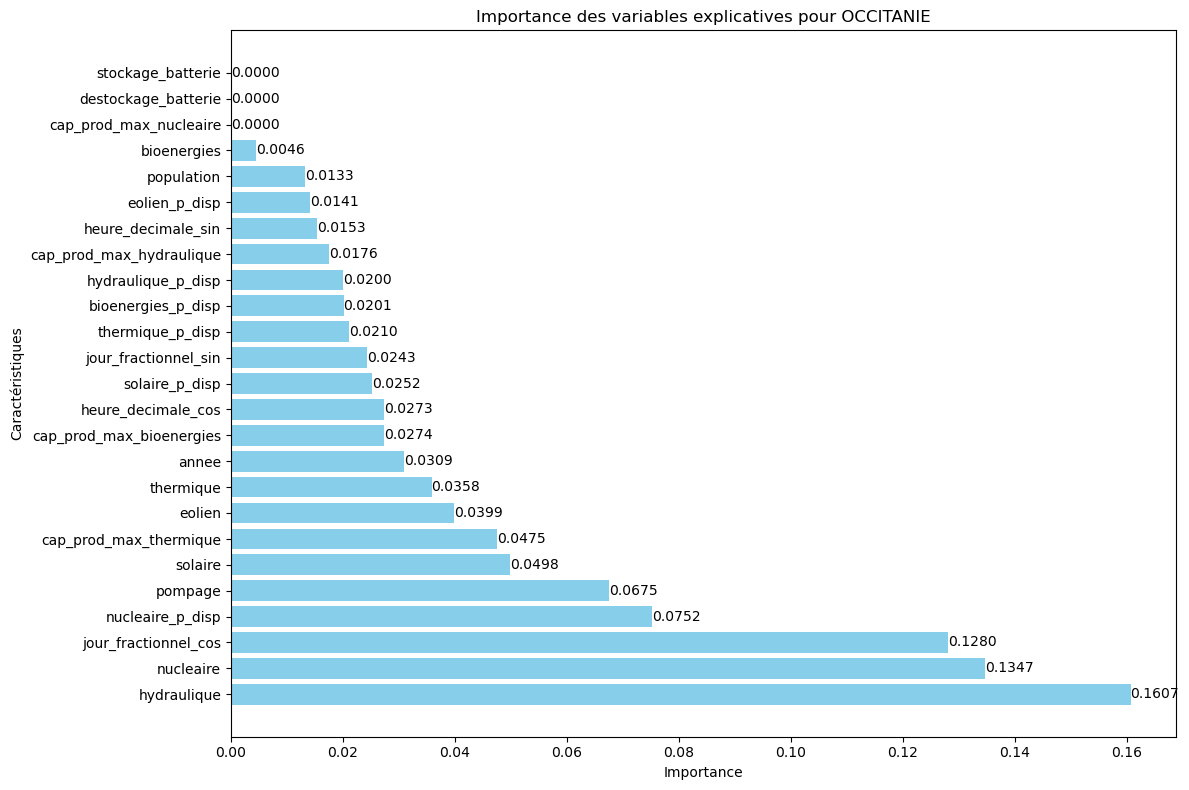

Entraînement du modèle XGBoost pour la région NORMANDIE...


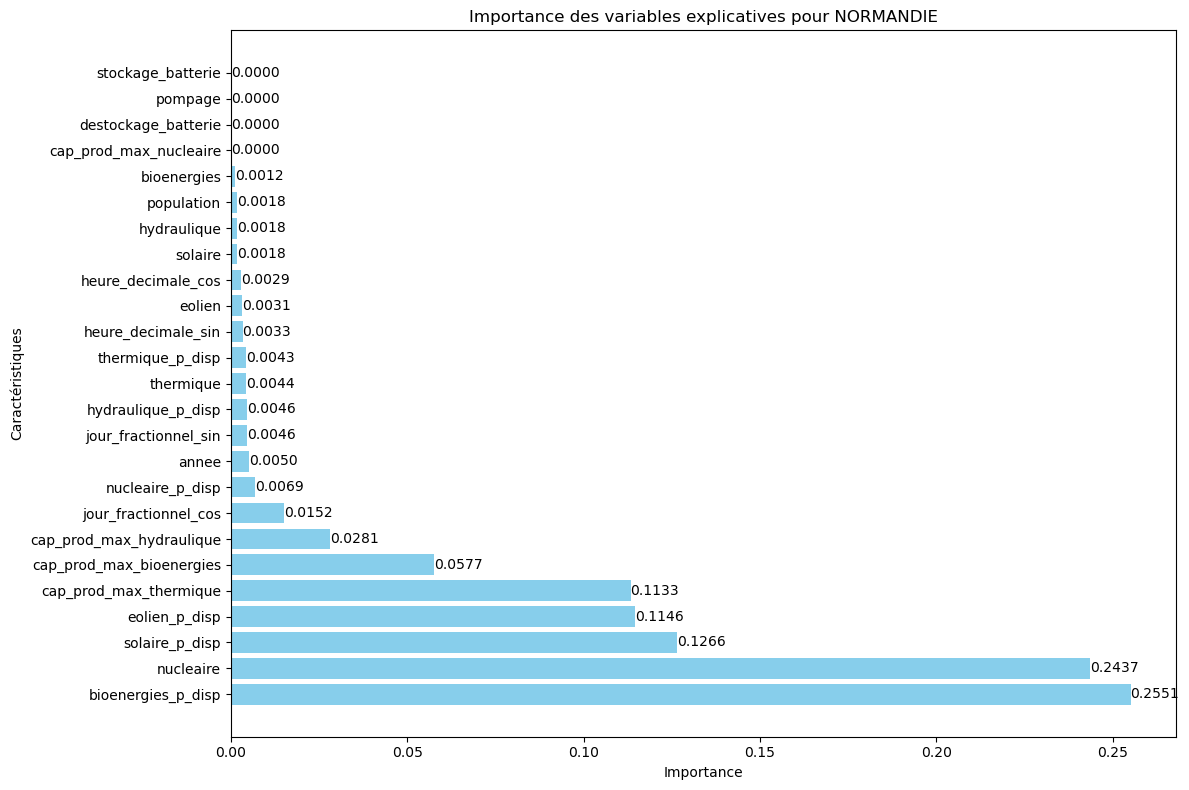

Entraînement du modèle XGBoost pour la région PROVENCE ALPES COTE D AZUR...


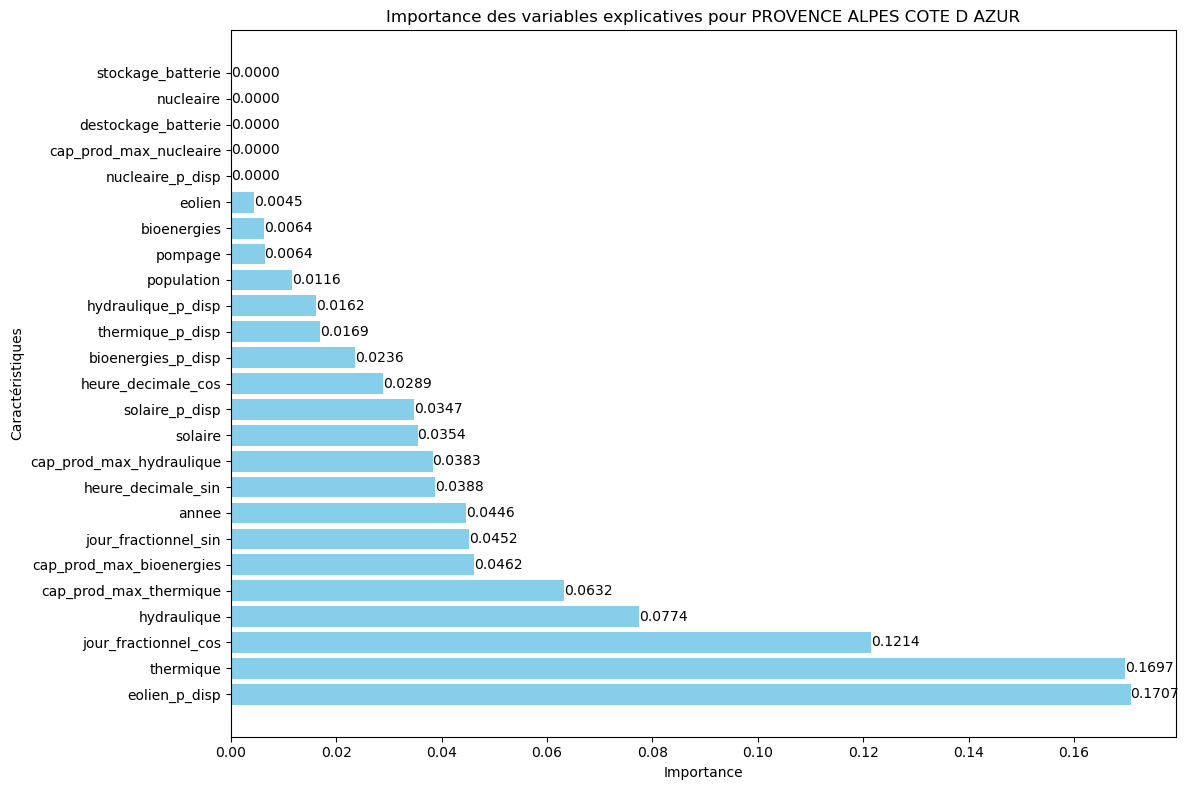

Entraînement du modèle XGBoost pour la région BOURGOGNE FRANCHE COMTE...


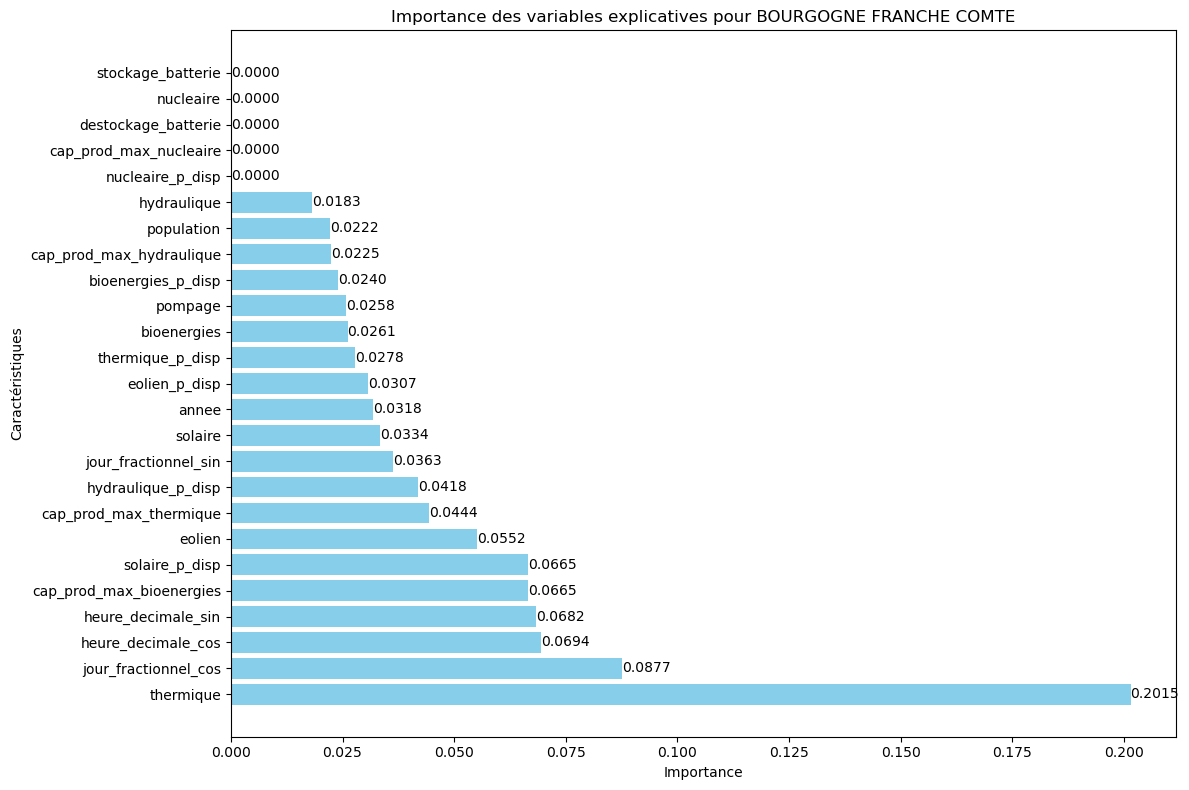

Entraînement du modèle XGBoost pour la région HAUTS DE FRANCE...


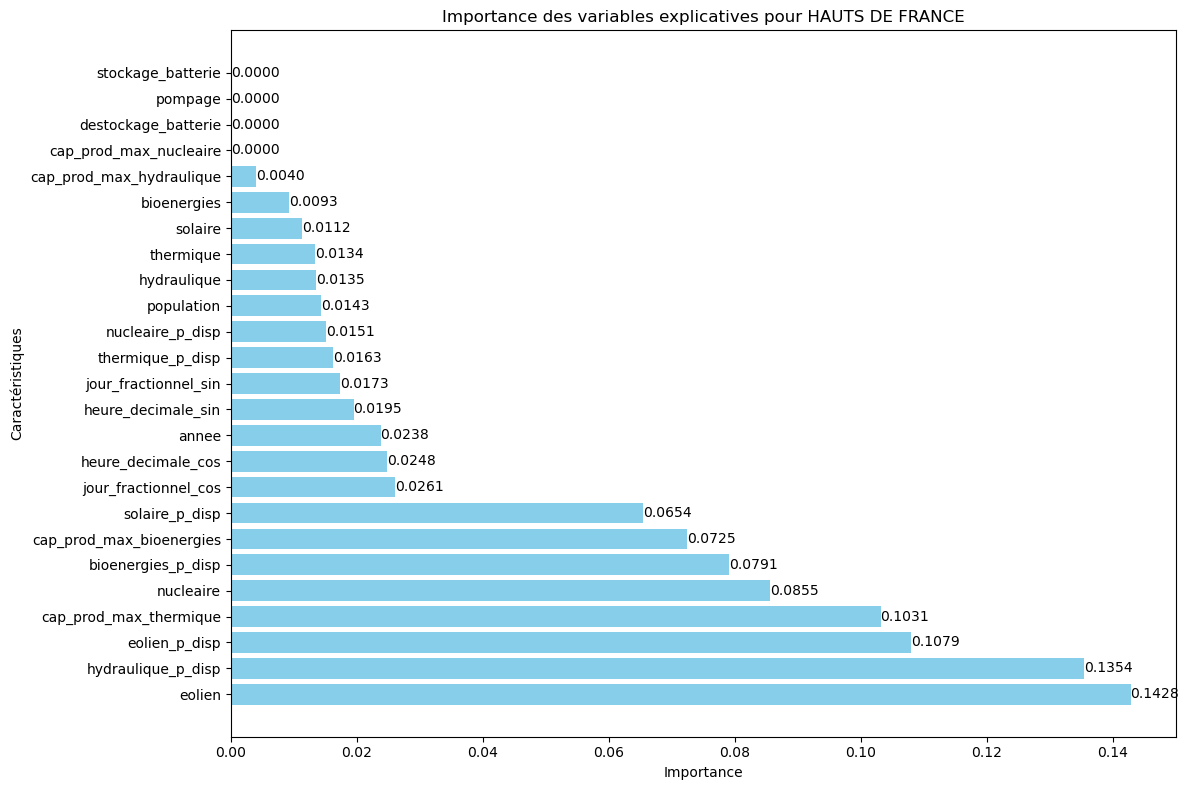

Entraînement du modèle XGBoost pour la région BRETAGNE...


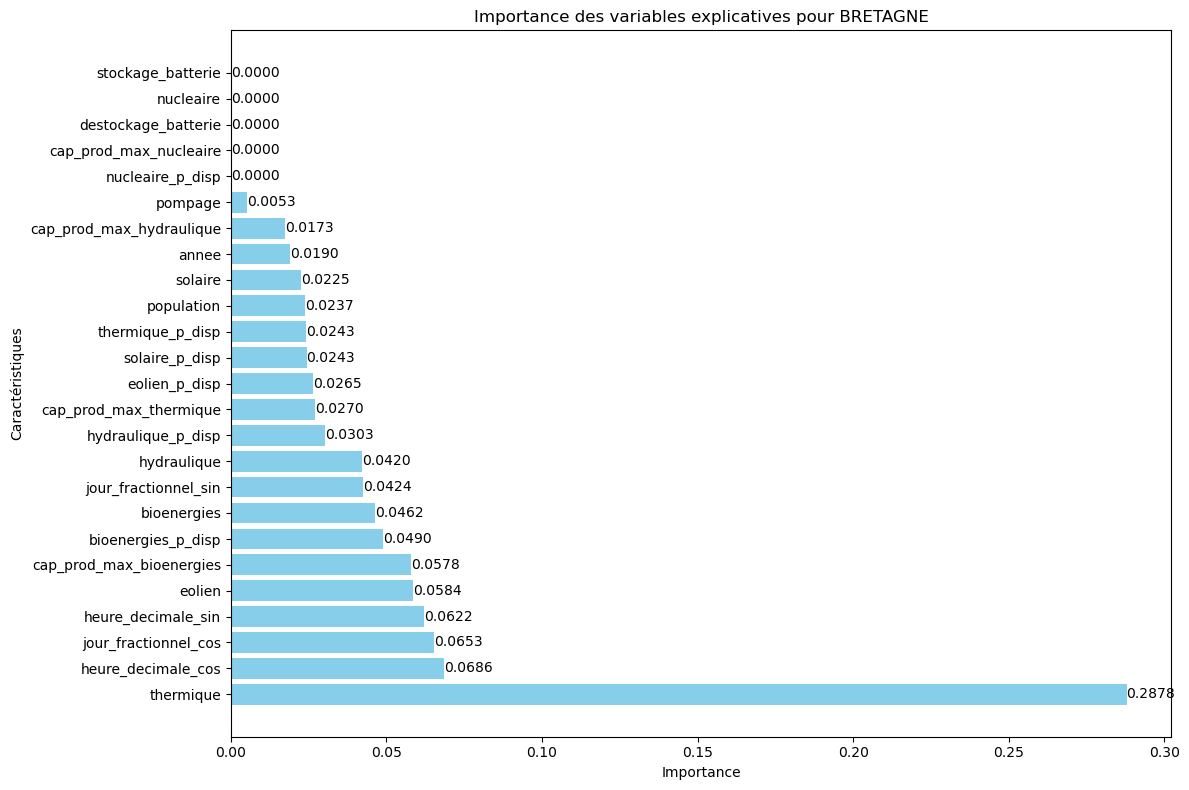

Entraînement du modèle XGBoost pour la région AUVERGNE RHONE ALPES...


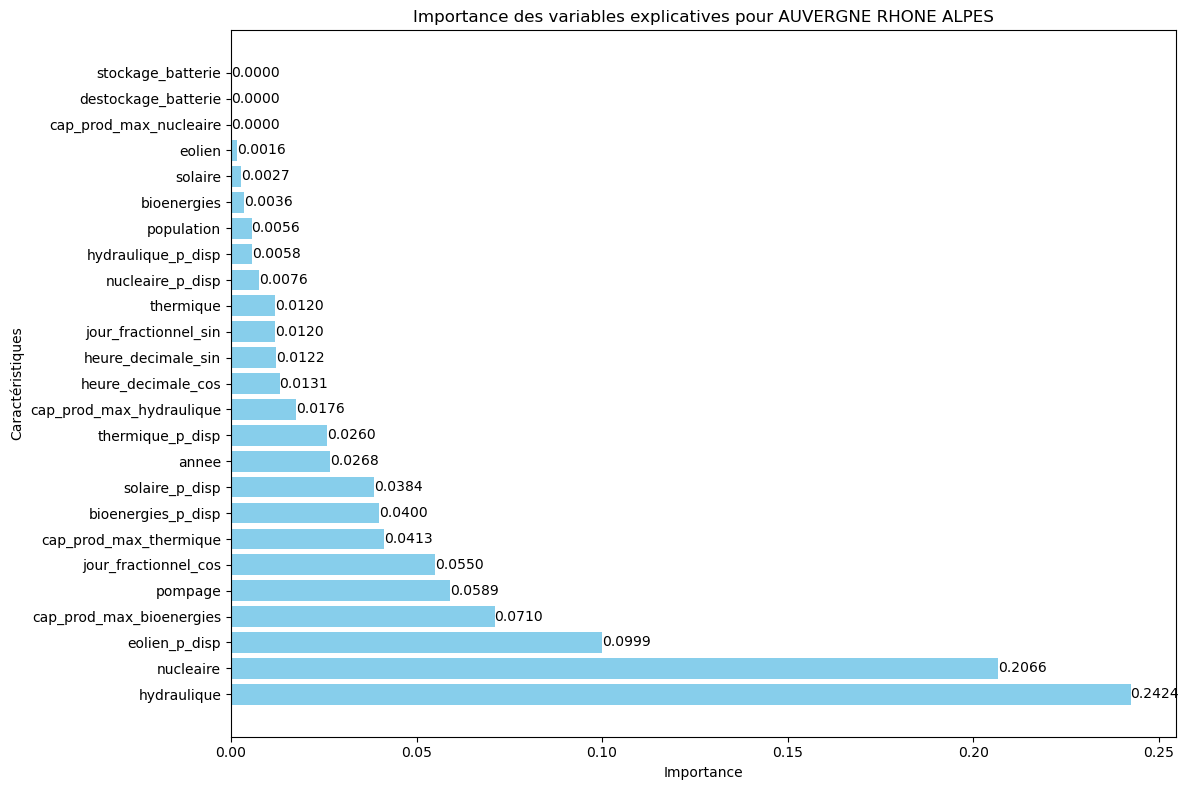

Entraînement du modèle XGBoost pour la région NOUVELLE AQUITAINE...


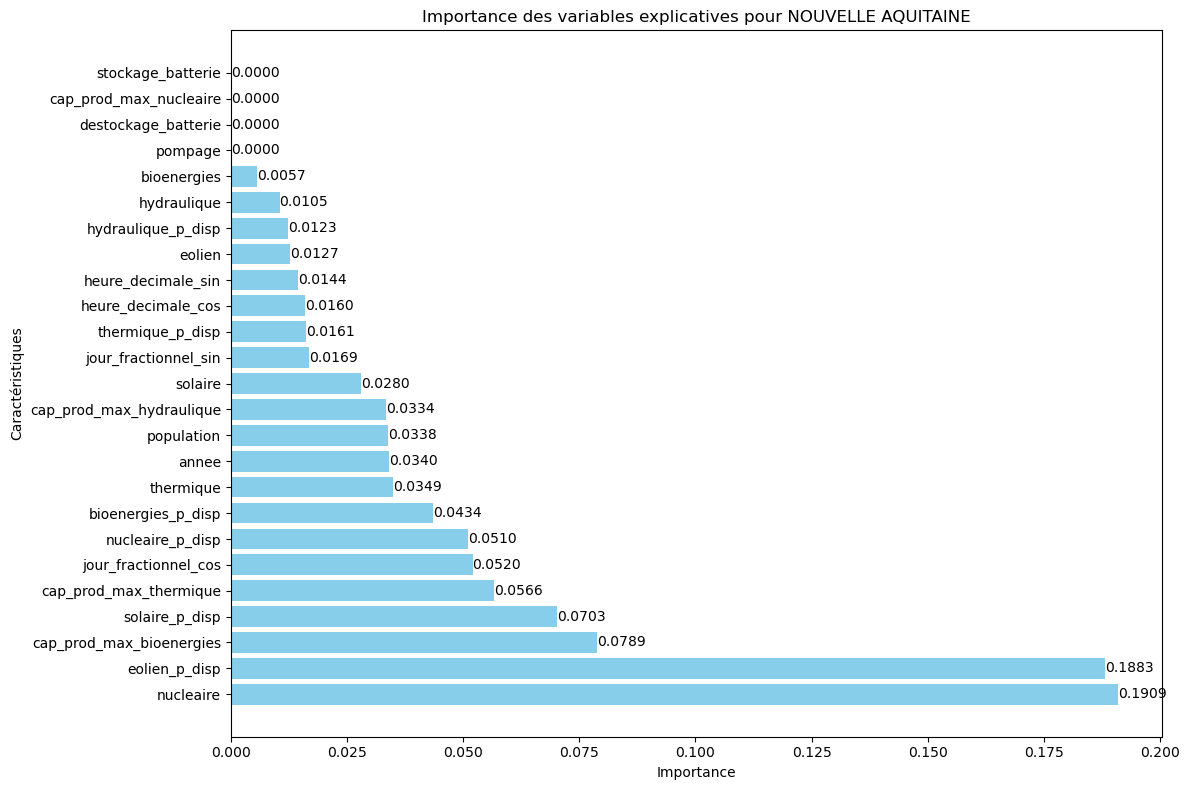

In [11]:
for region in df_blackout_ml_13_19['region'].unique():
    print(f"Entraînement du modèle XGBoost pour la région {region}...")
    
    df_region = df_blackout_ml_13_19[df_blackout_ml_13_19['region'] == region].copy()
    features_region_seg = df_region[['annee', 'jour_fractionnel_sin', 'jour_fractionnel_cos', 'heure_decimale_sin', 'heure_decimale_cos',
                          'thermique', 'nucleaire', 'eolien', 'solaire', 'hydraulique', 'bioenergies',
                          'pompage', 'stockage_batterie', 'destockage_batterie', 'cap_prod_max_thermique','thermique_p_disp',
                          'cap_prod_max_nucleaire', 'nucleaire_p_disp', 'cap_prod_max_hydraulique', 'hydraulique_p_disp',
                          'cap_prod_max_bioenergies','bioenergies_p_disp',
                          'solaire_p_disp', 'eolien_p_disp', 'population']]
    target_region_seg = df_region['ech_physiques']
    
    features_region_seg = pd.get_dummies(features_region_seg)
    
    X_train_region_seg, X_test_region, Y_train_region_seg, y_test_region_seg = train_test_split(features_region_seg, target_region_seg, test_size=0.2, random_state=42)
    
    scaler_region = StandardScaler()
    X_train_region_seg = scaler_region.fit_transform(X_train_region_seg)
    X_test_region = scaler_region.transform(X_test_region)
    
    xgb_model_seg = XGBRegressor(**xgb_params)
    xgb_model_seg.fit(X_train_region_seg, Y_train_region_seg)
    
    # Visualisation de l'importance des variables explicatives
    plot_feature_importance(xgb_model_seg, features_region_seg, region)
    
    # Prédictions pour 2020-2023
    df_region_20_23_seg = df_blackout_ml_20_23_seg[df_blackout_ml_20_23_seg['region'] == region].copy()
    features_region_seg_20_23 = df_region_20_23_seg[['annee', 'jour_fractionnel_sin', 'jour_fractionnel_cos', 'heure_decimale_sin', 'heure_decimale_cos',
                              'thermique', 'nucleaire', 'eolien', 'solaire', 'hydraulique', 'bioenergies',
                              'pompage', 'stockage_batterie', 'destockage_batterie', 'cap_prod_max_thermique','thermique_p_disp',
                              'cap_prod_max_nucleaire', 'nucleaire_p_disp', 'cap_prod_max_hydraulique', 'hydraulique_p_disp',
                              'cap_prod_max_bioenergies','bioenergies_p_disp',
                              'solaire_p_disp', 'eolien_p_disp', 'population']]
    features_region_seg_20_23 = pd.get_dummies(features_region_seg_20_23)
    features_region_seg_20_23 = scaler_region.transform(features_region_seg_20_23)
    
    df_region_20_23_seg['ech_physiques_pred_seg'] = xgb_model_seg.predict(features_region_seg_20_23)
    
    all_regions_df.append(df_region_20_23_seg)
    metrics_results_seg.append({
        'region': region,
        'MAE': mean_absolute_error(y_test_region_seg, xgb_model_seg.predict(X_test_region)),
        'MSE': mean_squared_error(y_test_region_seg, xgb_model_seg.predict(X_test_region)),
        'RMSE': np.sqrt(mean_squared_error(y_test_region_seg, xgb_model_seg.predict(X_test_region))),
        'R^2': r2_score(y_test_region_seg, xgb_model_seg.predict(X_test_region))
    })

In [12]:
# Combinaison des résultats pour toutes les régions
df_all_regions = pd.concat(all_regions_df)
df_metrics_results_seg = pd.DataFrame(metrics_results_seg)

In [13]:
# Exportation du DataFrame global
df_all_regions.to_csv("resultats_prev_xgb_seg.csv", index=False)

In [14]:
# Conversion des résultats des métriques en DataFrame
df_metrics = pd.DataFrame(metrics_results_seg)

In [15]:
# Enregistrement des métriques dans un fichier Excel
output_excel = "resultats_xgb_seg_metrics_20_23.xlsx"
with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
    df_metrics.to_excel(writer, index=False, sheet_name='Metriques')

In [16]:
print(f"Les métriques de performance ont été enregistrées dans le fichier {output_excel}")
print("Les graphiques d'importance des variables explicatives ont été sauvegardés.")

Les métriques de performance ont été enregistrées dans le fichier resultats_xgb_seg_metrics_20_23.xlsx
Les graphiques d'importance des variables explicatives ont été sauvegardés.
